<a href="https://colab.research.google.com/github/MarcosRoms/Deep_learning_colab/blob/main/Proyecto_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sheep Detecion

## Descargar datos

https://www.kaggle.com/code/transhumanistx/strawberry-dataset-prep-for-mask/input

In [ ]:
!kaggle datasets download -d usmanafzaal/strawberry-disease-detection-dataset

Dataset URL: https://www.kaggle.com/datasets/usmanafzaal/strawberry-disease-detection-dataset
License(s): unknown
100% 533M/534M [00:28<00:00, 21.7MB/s]
100% 534M/534M [00:28<00:00, 19.8MB/s]


In [ ]:
!mkdir strawberry-disease-detection-dataset
!unzip strawberry-disease-detection-dataset.zip -d strawberry-disease-detection-dataset

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: strawberry-disease-detection-dataset/test/angular_leafspot351.jpg  
  inflating: strawberry-disease-detection-dataset/test/angular_leafspot351.json  
  inflating: strawberry-disease-detection-dataset/test/angular_leafspot352.jpg  
  inflating: strawberry-disease-detection-dataset/test/angular_leafspot352.json  
  inflating: strawberry-disease-detection-dataset/test/angular_leafspot353.jpg  
  inflating: strawberry-disease-detection-dataset/test/angular_leafspot353.json  
  inflating: strawberry-disease-detection-dataset/test/angular_leafspot354.jpg  
  inflating: strawberry-disease-detection-dataset/test/angular_leafspot354.json  
  inflating: strawberry-disease-detection-dataset/test/angular_leafspot355.jpg  
  inflating: strawberry-disease-detection-dataset/test/angular_leafspot355.json  
  inflating: strawberry-disease-detection-dataset/test/angular_leafspot357.jpg  
  inflating: strawberry-disease-detec

## Acondicionamiento de los datos

In [ ]:
# Utils

import os
import xml.etree.ElementTree as ET
import shutil
import yaml
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import random
import json


def convert_to_yolo_format(size, box):
    """
    Convierte las coordenadas del bounding box al formato YOLO.

    Args:
        size (tuple): Tamaño de la imagen (ancho, alto).
        box (tuple): Coordenadas del bounding box (xmin, xmax, ymin, ymax).

    Returns:
        tuple: Coordenadas normalizadas (x, y, w, h) en formato YOLO.
    """
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (box[0] + box[1]) / 2.0 - 1
    y = (box[2] + box[3]) / 2.0 - 1
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return (x, y, w, h)

def convert_annotation(xml_path, labels_path, classes):
    """
    Convierte las anotaciones de un archivo XML a formato YOLO y las guarda en un archivo de texto.

    Args:
        xml_path (str): Ruta al archivo XML.
        labels_path (str): Ruta al archivo de texto donde se guardarán las anotaciones en formato YOLO.
        classes (list): Lista de clases detectadas en los archivos XML.
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text),
             float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
        bb = convert_to_yolo_format((w, h), b)
        with open(labels_path, 'a') as out_file:
            out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')

def create_folder(dir):
    """
    Crea el directorio si no existe.

    Args:
        labels_dir (str): Ruta al directorio.
    """
    if not os.path.exists(dir):
        os.makedirs(dir)

def find_classes(xml_dir):
    """
    Encuentra todas las clases en los archivos XML del directorio dado.

    Args:
        xml_dir (str): Ruta al directorio que contiene los archivos XML.

    Returns:
        list: Lista de clases encontradas.
    """
    classes = set()
    for filename in os.listdir(xml_dir):
        if filename.endswith(".xml"):
            xml_path = os.path.join(xml_dir, filename)
            tree = ET.parse(xml_path)
            root = tree.getroot()
            for obj in root.iter('object'):
                cls = obj.find('name').text
                classes.add(cls)
    return list(classes)

def save_classes(classes, file_path):
    """
    Guarda la lista de clases en un archivo de texto.

    Args:
        classes (list): Lista de clases.
        file_path (str): Ruta al archivo donde se guardarán las clases.
    """
    with open(file_path, 'w') as f:
        for cls in classes:
            f.write(cls + "\n")

def process_dataset(xml_dir, labels_dir, classes_file):
    """
    Procesa el conjunto de datos XML, encuentra las clases, las guarda y convierte las anotaciones a formato YOLO.

    Args:
        xml_dir (str): Ruta al directorio que contiene los archivos XML.
        labels_dir (str): Ruta al directorio donde se guardarán los archivos de etiquetas en formato YOLO.
        classes_file (str): Ruta al archivo donde se guardarán las clases.
    """
    create_folder(labels_dir)
    classes = find_classes(xml_dir)
    save_classes(classes, classes_file)
    for filename in os.listdir(xml_dir):
        if filename.endswith(".xml"):
            xml_path = os.path.join(xml_dir, filename)
            labels_path = os.path.join(labels_dir, filename.replace(".xml", ".txt"))
            convert_annotation(xml_path, labels_path, classes)

def move_images(source_dir, target_dir):
    """
    Mueve todas las imágenes de un directorio a otro, creando el directorio de destino si no existe.

    Args:
        source_dir (str): Ruta al directorio de origen.
        target_dir (str): Ruta al directorio de destino.
    """
    # Crear el directorio de destino si no existe
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    # Definir las extensiones de archivo de imagen comunes
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff']

    # Mover cada archivo de imagen al directorio de destino
    for filename in os.listdir(source_dir):
        if any(filename.lower().endswith(ext) for ext in image_extensions):
            source_path = os.path.join(source_dir, filename)
            target_path = os.path.join(target_dir, filename)
            shutil.move(source_path, target_path)
            print(f"Movido: {source_path} -> {target_path}")

def load_yaml_config(yaml_path):
    """
    Carga un archivo de configuración YAML.

    Args:
        yaml_path (str): Ruta al archivo YAML.

    Returns:
        dict: Contenido del YAML parseado.
    """
    with open(yaml_path, 'r') as file:
        return yaml.safe_load(file)

def count_classes(labels_dir):
    """
    Cuenta las ocurrencias de cada clase en los archivos de etiquetas de un directorio dado.

    Args:
        labels_dir (str): Ruta al directorio que contiene los archivos de etiquetas.

    Returns:
        Counter: Un objeto Counter con los conteos de clases.
    """
    class_counter = Counter()
    for label_file in os.listdir(labels_dir):
        if label_file.endswith('.txt'):
            with open(os.path.join(labels_dir, label_file), 'r') as file:
                for line in file:
                    class_id = int(line.split()[0])
                    class_counter[class_id] += 1
    return class_counter

def analyze_class_balance(config_path):
    """
    Analiza el balance de clases en el conjunto de datos según lo especificado en el archivo de configuración.

    Args:
        config_path (str): Ruta al archivo de configuración YAML.

    Returns:
        pd.DataFrame: DataFrame que contiene los conteos de clases para cada división del conjunto de datos.
    """
    config = load_yaml_config(config_path)
    classes = config['names']
    datasets = ['train', 'val', 'test']
    base_dir = os.path.dirname(config_path)

    results = {}
    for dataset in datasets:
        labels_dir = os.path.join(base_dir, dataset, 'labels')
        if os.path.exists(labels_dir):
            results[dataset] = count_classes(labels_dir)
        else:
            print(f"Advertencia: El directorio '{labels_dir}' no existe. Saltando el conjunto de datos {dataset}.")
            results[dataset] = Counter()

    # Creación del DataFrame
    df = pd.DataFrame({dataset: [results[dataset].get(i, 0) for i in range(len(classes))] for dataset in datasets}, index=classes)

    return df

def plot_class_balance(df):
    """
    Genera un gráfico de barras para visualizar el balance de clases en los diferentes conjuntos de datos.

    Args:
        df (pd.DataFrame): DataFrame que contiene los conteos de clases para cada división del conjunto de datos.
    """
    ax = df.plot(kind='bar', figsize=(10, 6), width=0.8)
    plt.title('Balance de Clases en los Conjuntos de Datos')
    plt.xlabel('Clases')
    plt.ylabel('Conteo')
    plt.xticks(rotation=45)
    plt.legend(title='Conjuntos de Datos')
    plt.tight_layout()
    plt.show()


def remove_directory_if_exists(directory_path):
    """
    Elimina un directorio si existe.

    Args:
        directory_path (str): La ruta del directorio a eliminar.
    """
    if os.path.exists(directory_path):
        shutil.rmtree(directory_path)
        print(f"Directorio '{directory_path}' eliminado exitosamente.")
    else:
        print(f"Directorio '{directory_path}' no existe.")



def split_dataset(source_folder, test_size=0.2, random_seed=None):
    """
    Divide el dataset en carpetas de entrenamiento y prueba con subcarpetas de imágenes y etiquetas dentro de la misma carpeta fuente.

    Parameters:
    - source_folder: Carpeta fuente que contiene subcarpetas de imágenes y etiquetas.
    - test_size: Proporción del dataset que se asignará al conjunto de prueba.
    - random_seed: Semilla para el generador de números aleatorios (para reproducibilidad).
    """
    if random_seed is not None:
        random.seed(random_seed)

    # Crear carpetas de destino dentro de la carpeta fuente
    train_images_folder = os.path.join(source_folder, 'train/images')
    train_labels_folder = os.path.join(source_folder, 'train/labels')
    test_images_folder = os.path.join(source_folder, 'test/images')
    test_labels_folder = os.path.join(source_folder, 'test/labels')

    os.makedirs(train_images_folder, exist_ok=True)
    os.makedirs(train_labels_folder, exist_ok=True)
    os.makedirs(test_images_folder, exist_ok=True)
    os.makedirs(test_labels_folder, exist_ok=True)

    # Obtener todas las imágenes y etiquetas en la carpeta fuente
    image_files = os.listdir(os.path.join(source_folder, 'images'))
    label_files = os.listdir(os.path.join(source_folder, 'labels'))

    # Asegurarse de que la lista de imágenes y etiquetas coincidan
    assert len(image_files) == len(label_files), "El número de imágenes y etiquetas no coincide"

    # Mezclar los archivos
    combined = list(zip(image_files, label_files))
    random.shuffle(combined)
    image_files[:], label_files[:] = zip(*combined)

    # Dividir los archivos en train y test
    split_index = int(len(image_files) * (1 - test_size))
    train_images = image_files[:split_index]
    test_images = image_files[split_index:]
    train_labels = label_files[:split_index]
    test_labels = label_files[split_index:]

    # Mover los archivos al conjunto de entrenamiento
    for img, lbl in zip(train_images, train_labels):
        shutil.move(os.path.join(source_folder, 'images', img), os.path.join(train_images_folder, img))
        shutil.move(os.path.join(source_folder, 'labels', lbl), os.path.join(train_labels_folder, lbl))

    # Mover los archivos al conjunto de prueba
    for img, lbl in zip(test_images, test_labels):
        shutil.move(os.path.join(source_folder, 'images', img), os.path.join(test_images_folder, img))
        shutil.move(os.path.join(source_folder, 'labels', lbl), os.path.join(test_labels_folder, lbl))

    print(f'Dataset dividido en {source_folder}/train y {source_folder}/test.')




def convert_polygon_to_yolo(points, img_width, img_height):
    """
    Convierte las coordenadas de un polígono al formato YOLO.

    Args:
        points (list): Lista de puntos (x, y) que forman el polígono.
        img_width (int): Ancho de la imagen.
        img_height (int): Alto de la imagen.

    Returns:
        tuple: Coordenadas normalizadas (x, y, w, h) en formato YOLO.
    """
    min_x = min([p[0] for p in points])
    max_x = max([p[0] for p in points])
    min_y = min([p[1] for p in points])
    max_y = max([p[1] for p in points])

    x_center = (min_x + max_x) / 2.0
    y_center = (min_y + max_y) / 2.0
    width = max_x - min_x
    height = max_y - min_y

    x_center /= img_width
    y_center /= img_height
    width /= img_width
    height /= img_height

    return (x_center, y_center, width, height)

def process_json_files(source_folder, output_folder, names = None):
    """
    Procesa archivos JSON que contienen anotaciones de polígonos y los convierte a formato YOLO.

    Args:
        source_folder (str): Ruta al directorio que contiene los archivos JSON.
        output_folder (str): Ruta al directorio donde se guardarán los archivos convertidos.

    Returns:
        dict: Mapeo de clases a sus respectivos identificadores.
    """
    class_mapping = {}
    class_counter = 0

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for json_file in os.listdir(source_folder):
        if json_file.endswith('.json'):
            json_path = os.path.join(source_folder, json_file)
            with open(json_path) as f:
                data = json.load(f)

            img_width = data['imageWidth']
            img_height = data['imageHeight']

            output_file = os.path.join(output_folder, os.path.basename(json_file).replace('.json', '.txt'))

            with open(output_file, 'w') as out_f:
                for shape in data['shapes']:
                    label = shape['label']
                    if names == None:
                      if label not in class_mapping:
                          class_mapping[label] = class_counter
                          class_counter += 1
                    else:
                      class_mapping = names

                    points = shape['points']
                    yolo_data = convert_polygon_to_yolo(points, img_width, img_height)
                    class_id = class_mapping[label]
                    yolo_line = f"{class_id} {yolo_data[0]} {yolo_data[1]} {yolo_data[2]} {yolo_data[3]}\n"
                    out_f.write(yolo_line)

    return class_mapping

### Cambiar de formato las etiquetas

In [ ]:
# En este caso se esta haciendo una adaptación de las etiquetas para realizar detección y no segmentación
# Entrenamiento
class_mapping = process_json_files(r'/content/strawberry-disease-detection-dataset/train',
                                   r'/content/strawberry-disease-detection-dataset/train/labels')

In [ ]:
class_mapping

{'Angular Leafspot': 0,
 'Gray Mold': 1,
 'Blossom Blight': 2,
 'Powdery Mildew Leaf': 3,
 'Leaf Spot': 4,
 'Anthracnose Fruit Rot': 5,
 'Powdery Mildew Fruit': 6}

In [ ]:
# Prueba
class_mapping = process_json_files(r'/content/strawberry-disease-detection-dataset/test',
                                   r'/content/strawberry-disease-detection-dataset/test/labels')

In [ ]:
class_mapping

{'Anthracnose Fruit Rot': 0,
 'Leaf Spot': 1,
 'Gray Mold': 2,
 'Blossom Blight': 3,
 'Angular Leafspot': 4,
 'Powdery Mildew Leaf': 5,
 'Powdery Mildew Fruit': 6}

In [ ]:
# Evaluacion
class_mapping = process_json_files(r'/content/strawberry-disease-detection-dataset/val',
                                   r'/content/strawberry-disease-detection-dataset/val/labels')

In [ ]:
class_mapping

{'Powdery Mildew Leaf': 0,
 'Gray Mold': 1,
 'Leaf Spot': 2,
 'Angular Leafspot': 3,
 'Blossom Blight': 4,
 'Powdery Mildew Fruit': 5,
 'Anthracnose Fruit Rot': 6}

### Mover imagenes


In [ ]:
move_images(r'/content/strawberry-disease-detection-dataset/val',
            r'/content/strawberry-disease-detection-dataset/val/images')

Movido: /content/strawberry-disease-detection-dataset/val/blossom_blight26.jpg -> /content/strawberry-disease-detection-dataset/val/images/blossom_blight26.jpg
Movido: /content/strawberry-disease-detection-dataset/val/powdery_mildew_leaf246.jpg -> /content/strawberry-disease-detection-dataset/val/images/powdery_mildew_leaf246.jpg
Movido: /content/strawberry-disease-detection-dataset/val/blossom_blight133.jpg -> /content/strawberry-disease-detection-dataset/val/images/blossom_blight133.jpg
Movido: /content/strawberry-disease-detection-dataset/val/blossom_blight33.jpg -> /content/strawberry-disease-detection-dataset/val/images/blossom_blight33.jpg
Movido: /content/strawberry-disease-detection-dataset/val/powdery_mildew_leaf264.jpg -> /content/strawberry-disease-detection-dataset/val/images/powdery_mildew_leaf264.jpg
Movido: /content/strawberry-disease-detection-dataset/val/gray_mold216.jpg -> /content/strawberry-disease-detection-dataset/val/images/gray_mold216.jpg
Movido: /content/straw

In [ ]:
move_images(r'/content/strawberry-disease-detection-dataset/test',
            r'/content/strawberry-disease-detection-dataset/test/images')

Movido: /content/strawberry-disease-detection-dataset/test/leaf_spot10.jpg -> /content/strawberry-disease-detection-dataset/test/images/leaf_spot10.jpg
Movido: /content/strawberry-disease-detection-dataset/test/powdery_mildew_leaf464.jpg -> /content/strawberry-disease-detection-dataset/test/images/powdery_mildew_leaf464.jpg
Movido: /content/strawberry-disease-detection-dataset/test/angular_leafspot393.jpg -> /content/strawberry-disease-detection-dataset/test/images/angular_leafspot393.jpg
Movido: /content/strawberry-disease-detection-dataset/test/leaf_spot519.jpg -> /content/strawberry-disease-detection-dataset/test/images/leaf_spot519.jpg
Movido: /content/strawberry-disease-detection-dataset/test/leaf_spot645.jpg -> /content/strawberry-disease-detection-dataset/test/images/leaf_spot645.jpg
Movido: /content/strawberry-disease-detection-dataset/test/powdery_mildew_leaf452.jpg -> /content/strawberry-disease-detection-dataset/test/images/powdery_mildew_leaf452.jpg
Movido: /content/strawbe

In [ ]:
move_images(r'/content/strawberry-disease-detection-dataset/train',
            r'/content/strawberry-disease-detection-dataset/train/images')

Movido: /content/strawberry-disease-detection-dataset/train/powdery_mildew_fruit74.jpg -> /content/strawberry-disease-detection-dataset/train/images/powdery_mildew_fruit74.jpg
Movido: /content/strawberry-disease-detection-dataset/train/angular_leafspot298.jpg -> /content/strawberry-disease-detection-dataset/train/images/angular_leafspot298.jpg
Movido: /content/strawberry-disease-detection-dataset/train/angular_leafspot205.jpg -> /content/strawberry-disease-detection-dataset/train/images/angular_leafspot205.jpg
Movido: /content/strawberry-disease-detection-dataset/train/powdery_mildew_leaf104.jpg -> /content/strawberry-disease-detection-dataset/train/images/powdery_mildew_leaf104.jpg
Movido: /content/strawberry-disease-detection-dataset/train/powdery_mildew_leaf30.jpg -> /content/strawberry-disease-detection-dataset/train/images/powdery_mildew_leaf30.jpg
Movido: /content/strawberry-disease-detection-dataset/train/leaf_spot69.jpg -> /content/strawberry-disease-detection-dataset/train/ima

## Crear el archivo de datos

In [ ]:
# Definir el contenido del archivo YAML
data = {
    'names': ['Angular Leafspot','Anthracnose Fruit Rot','Blossom Blight','Gray Mold','Leaf Spot','Powdery Mildew Fruit','Powdery Mildew Leaf'],
    'nc': 7,
    'train': '/content/strawberry-disease-detection-dataset/train',
    'val': '/content/strawberry-disease-detection-dataset/val',
    'test': '/content/strawberry-disease-detection-dataset/test'
}

path = r'/content/strawberry-disease-detection-dataset/data.yaml'

# Escribir el contenido en un archivo YAML
with open(path , 'w') as file:
    yaml.dump(data, file, default_flow_style=False)

print("Archivo data.yaml creado exitosamente.")

Archivo data.yaml creado exitosamente.


## Visualización de los datos

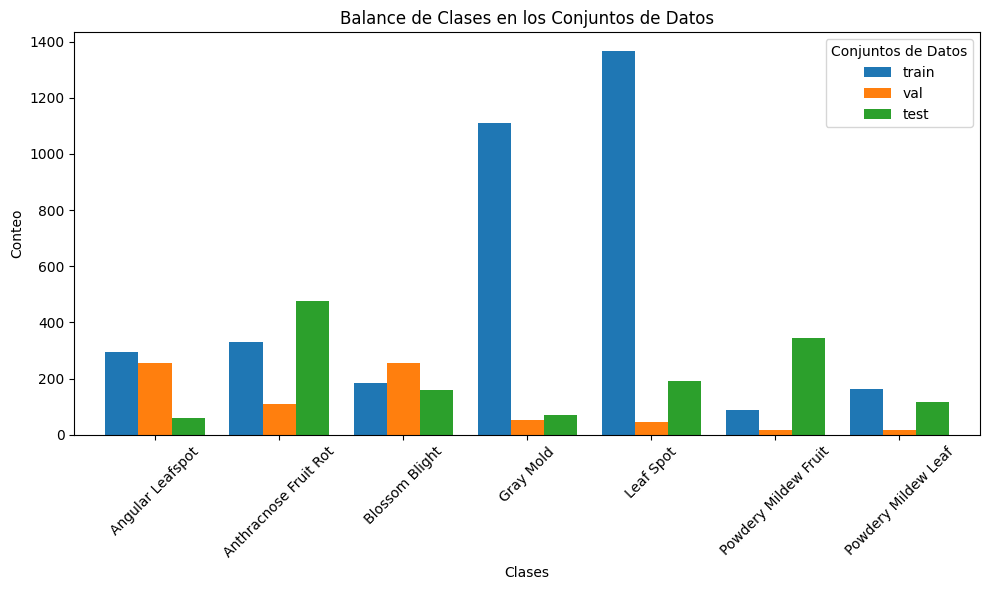

                       train  val  test
Angular Leafspot         294  255    58
Anthracnose Fruit Rot    332  108   478
Blossom Blight           186  257   158
Gray Mold               1110   52    70
Leaf Spot               1365   44   193
Powdery Mildew Fruit      89   18   343
Powdery Mildew Leaf      164   17   116


In [ ]:
class_balance_df = analyze_class_balance(path)
plot_class_balance(class_balance_df)
print(class_balance_df)

# Instalación de Ultralytics

In [ ]:
%pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

Descripción de la Arquitectura: https://docs.ultralytics.com/yolov5/tutorials/architecture_description/

In [ ]:
remove_directory_if_exists('/content/runs')

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov5nu.pt")  # Entrenamiento con pesos pre-entrenados

model.train(
    data=path,
    task="detect",
    mode='train',
    epochs=100,          # Número de épocas de entrenamiento
    patience=0,       # Paciencia para el early stopping
    batch=96,           # Tamaño del batch
    imgsz=640,          # Tamaño de la imagen
    save=True,          # Guardar el modelo después de entrenar
    cache=True,        # Usar caché de datos
    device=None,        # Dispositivo para el entrenamiento (None para auto-detectar)
    workers=8,          # Número de workers para el data loading
    pretrained=True,    # Usar pesos pre-entrenados
    optimizer='auto',   # Optimizador
    verbose=True,       # Imprimir información durante el entrenamiento
    seed=0,             # Semilla para la reproducibilidad
    deterministic=True, # Asegurar entrenamiento determinista
    amp=True,           # Mixed precision training
    val=True,           # Validar después de cada época
    split='val',        # División para validación
    iou=0.7,            # Umbral de IoU
    max_det=300,        # Máximo número de detecciones por imagen
    lr0=0.01,           # Tasa de aprendizaje inicial
    lrf=0.01,           # Factor de reducción de la tasa de aprendizaje
    momentum=0.937,     # Momento para SGD
    weight_decay=0.0005,# Decaimiento de peso
    warmup_epochs=3.0,  # Número de épocas de calentamiento
    warmup_momentum=0.8,# Momento durante el calentamiento
    warmup_bias_lr=0.1, # Tasa de aprendizaje para el sesgo durante el calentamiento
    box=7.5,            # Pérdida de la caja
    cls=0.5,            # Pérdida de la clase
    dfl=1.5,            # Pérdida de distribución focal
    mosaic=1.0,         # Probabilidad de aplicar la técnica de mosaic
    auto_augment='randaugment', # Tipo de aumento automático
    erasing=0.4,        # Probabilidad de borrado aleatorio
    save_dir='runs/detect/train', # Directorio para guardar los resultados
    name = 'exp-1'
)


100%|██████████| 5.31M/5.31M [00:00<00:00, 256MB/s]


Ultralytics YOLOv8.2.69 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov5nu.pt, data=/content/strawberry-disease-detection-dataset/data.yaml, epochs=100, time=None, patience=0, batch=96, imgsz=640, save=True, save_period=-1, cache=True, device=None, workers=8, project=None, name=exp-1, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels

100%|██████████| 755k/755k [00:00<00:00, 93.1MB/s]


Overriding model.yaml nc=80 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1      1760  ultralytics.nn.modules.conv.Conv             [3, 16, 6, 2, 2]              
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      4800  ultralytics.nn.modules.block.C3              [32, 32, 1]                   
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     29184  ultralytics.nn.modules.block.C3              [64, 64, 2]                   
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  3    156928  ultralytics.nn.modules.block.C3              [128, 128, 3]                 
  7                  -1  1    295424  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 293MB/s]


AMP: checks passed ✅


train: Scanning /content/strawberry-disease-detection-dataset/train/labels... 1450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1450/1450 [00:03<00:00, 450.41it/s]


train: New cache created: /content/strawberry-disease-detection-dataset/train/labels.cache


train: Caching images (1.7GB RAM): 100%|██████████| 1450/1450 [00:06<00:00, 212.64it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/strawberry-disease-detection-dataset/val/labels... 307 images, 0 backgrounds, 0 corrupt: 100%|██████████| 307/307 [00:00<00:00, 378.35it/s]


val: New cache created: /content/strawberry-disease-detection-dataset/val/labels.cache


val: Caching images (0.4GB RAM): 100%|██████████| 307/307 [00:05<00:00, 54.51it/s]


Plotting labels to runs/detect/exp-1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.00075), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/exp-1
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      13.4G      1.253      3.661      1.605         48        640: 100%|██████████| 16/16 [00:31<00:00,  1.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.72s/it]

                   all        307        751    0.00708      0.763     0.0166    0.00823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      12.4G     0.9572      2.711      1.389         72        640: 100%|██████████| 16/16 [00:23<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.27s/it]

                   all        307        751    0.00839      0.649     0.0474     0.0299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      12.2G     0.8951      1.932      1.351         47        640: 100%|██████████| 16/16 [00:22<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.14s/it]


                   all        307        751    0.00469       0.64     0.0354     0.0183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      12.2G      0.852      1.632      1.292         58        640: 100%|██████████| 16/16 [00:22<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.09s/it]

                   all        307        751      0.345      0.113     0.0654      0.035



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      12.1G     0.8273      1.469      1.267         50        640: 100%|██████████| 16/16 [00:22<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.56s/it]


                   all        307        751      0.292     0.0587     0.0766     0.0433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      12.5G     0.8227      1.369      1.246         80        640: 100%|██████████| 16/16 [00:23<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.24s/it]


                   all        307        751      0.351     0.0244     0.0718     0.0361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      12.3G     0.7842      1.253      1.207         59        640: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.42s/it]

                   all        307        751      0.367     0.0312     0.0572     0.0296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      12.3G     0.7833      1.172      1.199         47        640: 100%|██████████| 16/16 [00:23<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.59s/it]


                   all        307        751      0.206     0.0788     0.0491     0.0221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      12.1G     0.7581      1.114      1.189         55        640: 100%|██████████| 16/16 [00:23<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.12s/it]

                   all        307        751      0.194     0.0998     0.0587     0.0271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      12.5G     0.7264      1.056      1.161         46        640: 100%|██████████| 16/16 [00:22<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.18s/it]


                   all        307        751      0.178      0.111     0.0308     0.0142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      12.2G     0.7204       1.04      1.161         36        640: 100%|██████████| 16/16 [00:21<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.09s/it]

                   all        307        751     0.0504     0.0662     0.0545     0.0279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      12.2G     0.7244     0.9997      1.159         47        640: 100%|██████████| 16/16 [00:23<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.17s/it]

                   all        307        751      0.049     0.0702     0.0409     0.0201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      12.1G     0.7093     0.9509       1.14         65        640: 100%|██████████| 16/16 [00:22<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.06s/it]

                   all        307        751      0.209     0.0773     0.0604       0.03



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      12.3G     0.7113     0.9193      1.139         61        640: 100%|██████████| 16/16 [00:24<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.89s/it]

                   all        307        751      0.198     0.0887     0.0503     0.0247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      12.3G     0.6865     0.9014      1.121         41        640: 100%|██████████| 16/16 [00:22<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.93s/it]


                   all        307        751       0.19      0.114     0.0482     0.0229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      12.3G     0.6791     0.8636      1.115         75        640: 100%|██████████| 16/16 [00:22<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.06s/it]

                   all        307        751      0.231      0.113     0.0623     0.0267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      12.3G      0.677     0.8522      1.113         76        640: 100%|██████████| 16/16 [00:22<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.31s/it]


                   all        307        751       0.23     0.0984     0.0765     0.0343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      12.3G     0.6721       0.83      1.121         70        640: 100%|██████████| 16/16 [00:22<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.80s/it]

                   all        307        751      0.227     0.0732     0.0829     0.0389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      12.2G     0.6556     0.7938      1.103         70        640: 100%|██████████| 16/16 [00:24<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.01s/it]

                   all        307        751     0.0912      0.105      0.089     0.0426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      12.3G     0.6401     0.8011      1.091         57        640: 100%|██████████| 16/16 [00:23<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.15s/it]

                   all        307        751      0.211     0.0867     0.0576      0.028



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      12.1G     0.6482     0.7769      1.097         54        640: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.86s/it]

                   all        307        751      0.229      0.113     0.0703     0.0346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      12.4G     0.6282      0.745      1.091         51        640: 100%|██████████| 16/16 [00:22<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.80s/it]

                   all        307        751      0.262      0.102     0.0856     0.0474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      12.5G     0.6411     0.7535       1.09         54        640: 100%|██████████| 16/16 [00:23<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]

                   all        307        751      0.235     0.0899     0.0963     0.0517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      12.2G     0.6207     0.7236      1.077         40        640: 100%|██████████| 16/16 [00:22<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.17s/it]

                   all        307        751      0.227     0.0907     0.0858     0.0457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      12.3G     0.6339     0.7263      1.093         41        640: 100%|██████████| 16/16 [00:23<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.92s/it]

                   all        307        751      0.239     0.0741     0.0882     0.0473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      12.5G     0.6204     0.7154      1.082         40        640: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.81s/it]

                   all        307        751     0.0995     0.0675     0.0737     0.0409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      12.1G     0.6209     0.7012      1.074         56        640: 100%|██████████| 16/16 [00:23<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.02s/it]

                   all        307        751      0.229      0.082     0.0958     0.0507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      12.4G     0.6127     0.6827       1.07         87        640: 100%|██████████| 16/16 [00:25<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.92s/it]

                   all        307        751      0.268      0.109      0.106     0.0562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      12.5G      0.615     0.6896      1.073         69        640: 100%|██████████| 16/16 [00:22<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  3.00s/it]

                   all        307        751      0.251     0.0812     0.0659     0.0333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      12.3G     0.6027     0.6726       1.07         43        640: 100%|██████████| 16/16 [00:23<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.84s/it]

                   all        307        751      0.254     0.0999     0.0837     0.0387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      12.1G     0.6037     0.6538      1.057         70        640: 100%|██████████| 16/16 [00:24<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.63s/it]

                   all        307        751     0.0964     0.0983     0.0819      0.047



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      12.3G     0.5746     0.6379      1.045         64        640: 100%|██████████| 16/16 [00:23<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]

                   all        307        751     0.0731     0.0825     0.0756     0.0362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      12.5G     0.5952     0.6554      1.064         69        640: 100%|██████████| 16/16 [00:25<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.89s/it]

                   all        307        751      0.229     0.0703     0.0769     0.0425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      12.2G     0.5855     0.6413      1.057         54        640: 100%|██████████| 16/16 [00:22<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.71s/it]

                   all        307        751      0.234      0.101      0.103     0.0575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      12.3G     0.5943     0.6398      1.058         67        640: 100%|██████████| 16/16 [00:23<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.92s/it]

                   all        307        751      0.105      0.133      0.106     0.0567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      12.3G     0.5706     0.6195       1.05         64        640: 100%|██████████| 16/16 [00:23<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.09s/it]

                   all        307        751      0.253      0.121     0.0924     0.0469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      12.2G     0.5853      0.618      1.052         47        640: 100%|██████████| 16/16 [00:22<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.85s/it]

                   all        307        751      0.244      0.119      0.104     0.0583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      12.2G     0.5914     0.6079       1.05         68        640: 100%|██████████| 16/16 [00:22<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.86s/it]

                   all        307        751     0.0856      0.113      0.101     0.0573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      12.3G     0.5645     0.5947      1.042         73        640: 100%|██████████| 16/16 [00:22<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.82s/it]

                   all        307        751      0.106     0.0908        0.1     0.0518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      12.4G     0.5743     0.5907      1.045         58        640: 100%|██████████| 16/16 [00:22<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.04s/it]

                   all        307        751     0.0893      0.107     0.0628     0.0316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      12.3G     0.5651     0.5755       1.04         50        640: 100%|██████████| 16/16 [00:22<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.35s/it]

                   all        307        751     0.0971      0.106     0.0999     0.0601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      12.2G     0.5644     0.5856      1.045         51        640: 100%|██████████| 16/16 [00:22<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]

                   all        307        751       0.12      0.111      0.111      0.061



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      12.4G     0.5487     0.5783      1.035         42        640: 100%|██████████| 16/16 [00:21<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.07s/it]

                   all        307        751     0.0968       0.11      0.113     0.0657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      12.3G     0.5588     0.5695      1.032         67        640: 100%|██████████| 16/16 [00:21<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.01s/it]

                   all        307        751     0.0985      0.112      0.108     0.0595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      12.5G     0.5464     0.5633      1.028         51        640: 100%|██████████| 16/16 [00:23<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.00s/it]

                   all        307        751      0.083      0.119     0.0976      0.053



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      12.3G     0.5514     0.5597       1.03         76        640: 100%|██████████| 16/16 [00:23<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.83s/it]

                   all        307        751      0.262      0.108      0.114     0.0679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      12.3G     0.5391     0.5608      1.027         44        640: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.62s/it]

                   all        307        751      0.105     0.0966      0.114     0.0673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      12.3G     0.5377     0.5411      1.023         66        640: 100%|██████████| 16/16 [00:22<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.15s/it]

                   all        307        751      0.267      0.111      0.113     0.0675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      12.3G     0.5574     0.5523      1.033         79        640: 100%|██████████| 16/16 [00:23<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.82s/it]

                   all        307        751     0.0938     0.0952      0.115     0.0658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      12.4G     0.5451     0.5445      1.029         62        640: 100%|██████████| 16/16 [00:22<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.99s/it]

                   all        307        751      0.112     0.0967       0.11     0.0637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      12.2G      0.544     0.5444      1.027         37        640: 100%|██████████| 16/16 [00:21<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.76s/it]

                   all        307        751     0.0944      0.137      0.115     0.0688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      12.1G      0.529     0.5271      1.019         53        640: 100%|██████████| 16/16 [00:22<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.09s/it]

                   all        307        751     0.0964        0.1     0.0995     0.0584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      12.3G     0.5325     0.5179      1.014         76        640: 100%|██████████| 16/16 [00:23<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.75s/it]

                   all        307        751      0.123      0.132     0.0961     0.0539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      12.3G     0.5373     0.5356      1.017         86        640: 100%|██████████| 16/16 [00:24<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.21s/it]

                   all        307        751      0.109     0.0984      0.105     0.0602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      12.3G     0.5248     0.5124      1.016         67        640: 100%|██████████| 16/16 [00:22<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.53s/it]

                   all        307        751      0.107      0.138      0.116     0.0661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      12.3G     0.5256     0.5233      1.013         73        640: 100%|██████████| 16/16 [00:22<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.74s/it]

                   all        307        751      0.109      0.102      0.118     0.0734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      12.3G      0.518     0.5021      1.012         59        640: 100%|██████████| 16/16 [00:21<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.12s/it]

                   all        307        751      0.102      0.104      0.106     0.0618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      12.3G     0.5199     0.5146      1.016         49        640: 100%|██████████| 16/16 [00:22<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.88s/it]

                   all        307        751       0.13       0.11      0.124     0.0735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      12.3G     0.5184     0.4949      1.013         68        640: 100%|██████████| 16/16 [00:23<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.57s/it]

                   all        307        751      0.118      0.108      0.123     0.0735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      12.5G     0.5184     0.5081      1.015         42        640: 100%|██████████| 16/16 [00:22<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.27s/it]

                   all        307        751      0.109      0.127      0.109      0.063



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      12.3G     0.5092     0.4983       1.01         62        640: 100%|██████████| 16/16 [00:24<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.82s/it]

                   all        307        751     0.0931      0.142      0.115     0.0679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      12.5G     0.5103     0.4944      1.009         52        640: 100%|██████████| 16/16 [00:22<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.64s/it]

                   all        307        751      0.119      0.102      0.118      0.071



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      12.2G     0.5118     0.4953      1.003         82        640: 100%|██████████| 16/16 [00:22<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.90s/it]

                   all        307        751      0.111     0.0966      0.117     0.0649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      12.2G     0.5014     0.4854      1.008         55        640: 100%|██████████| 16/16 [00:22<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.91s/it]

                   all        307        751      0.119      0.145      0.122      0.071



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      12.2G      0.497     0.4838     0.9985         47        640: 100%|██████████| 16/16 [00:22<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.74s/it]

                   all        307        751      0.107      0.124      0.116     0.0657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      12.3G     0.4985     0.4757      1.001         58        640: 100%|██████████| 16/16 [00:22<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.88s/it]

                   all        307        751      0.125      0.113      0.129     0.0723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      12.1G     0.4986     0.4679      1.001         50        640: 100%|██████████| 16/16 [00:21<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]

                   all        307        751      0.112      0.146       0.13     0.0772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      12.3G     0.4921     0.4647      0.995         47        640: 100%|██████████| 16/16 [00:23<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.76s/it]

                   all        307        751      0.123      0.112      0.121     0.0703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      12.4G     0.4965     0.4661     0.9952         61        640: 100%|██████████| 16/16 [00:21<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.86s/it]

                   all        307        751      0.109      0.107      0.127     0.0766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      12.4G     0.5044      0.472      1.004         62        640: 100%|██████████| 16/16 [00:24<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.78s/it]

                   all        307        751      0.131     0.0966      0.123     0.0723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      12.2G     0.4864     0.4784     0.9922         72        640: 100%|██████████| 16/16 [00:22<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.18s/it]

                   all        307        751      0.123      0.114      0.119     0.0709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      12.3G     0.4827     0.4513      0.987         71        640: 100%|██████████| 16/16 [00:23<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.81s/it]

                   all        307        751      0.107      0.136      0.123     0.0773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      12.5G     0.4849     0.4597     0.9966         50        640: 100%|██████████| 16/16 [00:21<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.28s/it]

                   all        307        751      0.132      0.102      0.127     0.0777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      12.2G     0.4758      0.449     0.9927         72        640: 100%|██████████| 16/16 [00:22<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.79s/it]

                   all        307        751      0.129      0.114      0.129     0.0801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      12.1G     0.4863     0.4517     0.9937         66        640: 100%|██████████| 16/16 [00:22<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.78s/it]

                   all        307        751      0.118      0.144      0.126     0.0807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      12.4G     0.4698     0.4392      0.986         62        640: 100%|██████████| 16/16 [00:21<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.80s/it]

                   all        307        751      0.119      0.108      0.119     0.0732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      12.5G     0.4631     0.4398      0.987         48        640: 100%|██████████| 16/16 [00:22<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.07s/it]

                   all        307        751      0.133      0.134      0.124     0.0789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      12.3G     0.4769     0.4423     0.9906         45        640: 100%|██████████| 16/16 [00:22<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.74s/it]

                   all        307        751      0.103      0.116      0.122     0.0751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      12.1G     0.4586     0.4268     0.9811         70        640: 100%|██████████| 16/16 [00:23<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.74s/it]

                   all        307        751      0.124      0.116      0.124       0.08



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      12.2G     0.4636     0.4309     0.9849         68        640: 100%|██████████| 16/16 [00:22<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.80s/it]

                   all        307        751      0.112      0.107      0.126     0.0796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      12.3G     0.4664     0.4392     0.9779         47        640: 100%|██████████| 16/16 [00:24<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.79s/it]

                   all        307        751      0.104      0.133      0.126     0.0804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      12.4G      0.466     0.4383      0.987         46        640: 100%|██████████| 16/16 [00:22<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.34s/it]

                   all        307        751      0.101      0.154      0.134     0.0839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      12.1G     0.4631     0.4249     0.9854         80        640: 100%|██████████| 16/16 [00:22<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.81s/it]

                   all        307        751      0.125      0.133      0.129     0.0807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      12.3G     0.4603      0.428     0.9746         73        640: 100%|██████████| 16/16 [00:22<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.85s/it]

                   all        307        751     0.0939      0.135      0.125     0.0784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      12.5G     0.4637     0.4246     0.9838         48        640: 100%|██████████| 16/16 [00:21<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]

                   all        307        751       0.12      0.138      0.135     0.0816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      12.3G     0.4503     0.4106     0.9842         64        640: 100%|██████████| 16/16 [00:21<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.54s/it]

                   all        307        751      0.121       0.15      0.134     0.0799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      12.4G      0.445     0.4037     0.9722         64        640: 100%|██████████| 16/16 [00:22<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]

                   all        307        751      0.121      0.117      0.132     0.0815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      12.2G      0.448     0.4086     0.9713         80        640: 100%|██████████| 16/16 [00:23<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.73s/it]

                   all        307        751      0.126      0.127      0.129     0.0803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      12.3G     0.4384     0.4081     0.9657         74        640: 100%|██████████| 16/16 [00:22<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.89s/it]

                   all        307        751      0.129      0.106      0.132     0.0813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      12.2G     0.4471     0.4022     0.9731         58        640: 100%|██████████| 16/16 [00:23<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.27s/it]

                   all        307        751      0.113      0.118      0.136     0.0848


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      12.3G     0.5365     0.6076      1.047         21        640: 100%|██████████| 16/16 [00:28<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.70s/it]

                   all        307        751      0.109     0.0939       0.11     0.0547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      12.3G     0.4829     0.4473      1.008         34        640: 100%|██████████| 16/16 [00:20<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.85s/it]

                   all        307        751      0.107     0.0911      0.115     0.0666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      12.3G     0.4533     0.4103     0.9808         27        640: 100%|██████████| 16/16 [00:21<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.16s/it]

                   all        307        751      0.124      0.107      0.137     0.0847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      12.3G     0.4667      0.407     0.9949         19        640: 100%|██████████| 16/16 [00:21<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.76s/it]

                   all        307        751      0.128      0.106      0.137     0.0864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      12.3G     0.4617      0.417     0.9953         19        640: 100%|██████████| 16/16 [00:21<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.80s/it]

                   all        307        751      0.124      0.115      0.138     0.0875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      12.3G     0.4553     0.3835      0.991         16        640: 100%|██████████| 16/16 [00:21<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.75s/it]

                   all        307        751      0.123      0.115      0.136      0.086



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      12.3G     0.4511     0.3915     0.9884         25        640: 100%|██████████| 16/16 [00:19<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.50s/it]

                   all        307        751      0.125      0.116      0.138     0.0886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      12.3G      0.433     0.3694     0.9644         26        640: 100%|██████████| 16/16 [00:20<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.85s/it]

                   all        307        751      0.108      0.146      0.136     0.0884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      12.3G     0.4427     0.3712     0.9783         22        640: 100%|██████████| 16/16 [00:19<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.41s/it]

                   all        307        751      0.122      0.116      0.138     0.0887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      12.5G     0.4378     0.3719     0.9774         38        640: 100%|██████████| 16/16 [00:21<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.67s/it]

                   all        307        751      0.122      0.115      0.137     0.0895



100 epochs completed in 0.820 hours.
Optimizer stripped from runs/detect/exp-1/weights/last.pt, 5.3MB
Optimizer stripped from runs/detect/exp-1/weights/best.pt, 5.3MB

Validating runs/detect/exp-1/weights/best.pt...
Ultralytics YOLOv8.2.69 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv5n summary (fused): 193 layers, 2,504,309 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.65s/it]


                   all        307        751      0.122      0.115      0.137     0.0897
      Angular Leafspot         63        255          0          0          0          0
 Anthracnose Fruit Rot         77        108      0.855      0.806      0.849       0.55
        Blossom Blight         71        257          0          0          0          0
             Gray Mold         43         52          0          0          0          0
             Leaf Spot         29         44          0          0    0.00543    0.00438
  Powdery Mildew Fruit         12         18          0          0    0.00734    0.00428
   Powdery Mildew Leaf         12         17          0          0     0.0976     0.0694
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/exp-1


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7eed019b39d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
  

## Evaluación del modelo entrenado

https://docs.ultralytics.com/modes/val/

In [ ]:
metrics = model.val(imgsz = 640, split = 'test', plots = True, name = 'Metrics-test-exp-1')

In [ ]:
metrics = model.val(imgsz = 640, split = 'val', plots = True, name = 'Metrics-val-exp-1')

# Predicciones

In [ ]:
from ultralytics import YOLO
model = YOLO(r"D:\Diplomado-IA\Modulo_5_extendido\Proyecto_4\runs\detect\exp-1\weights\best.pt")

In [ ]:
model.predict(r'D:\Diplomado-IA\Modulo_5_extendido\Proyecto_4\strawberry-disease-detection-dataset\test\images', save=True, imgsz=640, conf=0.7, save_txt = True, save_conf = False)